# Graph Cuts, Algorithms and Applications

I implemented Kargers randomized Min Cut algorithm, the improved Karger-Stein randomized Mincut algorithm as well as an Algorithm for approximating the Normalized Cut of a graph which I applied to Image Segmentation. 

The Min Cut algorithms are structured to fit in with the LightGraphs.jl package for Graphs in Julia. 

In [1]:
using GraphPlot, LightGraphs, Networks;
using Base.Collections
#Pkg.add("Benchmarks")
using BenchmarkTools

The Minimum cut of a graph is the set of edges with minimum weight such that if removed, the graph is disconnected



![title](mincut.png)

Mincut is often brought up as a result of a fun theorem called the mincut-maxflow theorem which is itself a special case of a more general property of linear programming. 

The Mincut-Maxflow theorem says that in a directed graph, the maximum flow that can travel from one vertex S to another Vertex T, is equal to the minimum cut that disconnects S and T.

As a consequence, the global minimum cut for a graph is equal to the maximum flow between any two vertices of a graph.

## Kargers mincut algorithm

There exist max flow algorithms that take $O(V^2*E)$ so a naive way to find the mincut could be to do all V choose 2 max flows which would be $O(V^4*E)$ which is slow and seems dumb. If we assume the graph is dense and $E \approx V^2$ then the algorithm is $O(V^6)$ which is dreadful. 

So can we do better?

Maybe not exactly, but (David) Karger (faculty member at MIT) came up with a randomized algorithm that probably will find the answer, much faster than the previously mentioned method.

The mincut of a graph with 2 Vertices is easy! There is only one cut! So the basic gameplan is to reduce the big graph, to one with only 2 super-vertices!

The main operation is squishing vertices together. Take U, V to UV with every edge from U and V still included and any vertex that had an edge from each U and V, becomes one edges with the two weights summed

Pseudocode is this:

    While number of Vertices >2:

        pick edge at random (u,v)
    
        squish u and v together   
    
    return cut
 

![title](karger.png)

So that gives a cut, but this seems like a pretty terrible idea. There almost no chance that will give the right answer!

That is true! But it is fast (How fast? $O(E)$)! And there is a non-zero chance of being correct! So if we do it a lot, it won't take a lot of time and eventually it'll be right!

The tough part is how many times do we need to try?

Turns out about $O(V^2*log(V))$ to get the probability of being wrong down to $1/|V|$

In $O(V^2*E*log(V))$ time, I can find the mincut with 1-1/V probability. Even in a dense graph, this is $O(V^4*log(V))$ which is much faster that $O(V^6)$

The LightGraphs.jl only supports unweighted graphs. In order to accomodate weighted graphs (which is necessary for most useful mincut applications), we must pass in an adjacency matrix where the (i, j) entry corresponds to the weight of the edge from vertex i to vertex j. By definition, the diagonal is zero. 

In [13]:
#my implementation
function matrix_mincut(mat)
    top = size(mat)[1]
    inds = collect(1:top)
    while size(inds)[1]>2
        pick = rand(inds)
        pick2 = rand(inds)
        while pick==pick2
            pick2 = rand(inds)
        end
        mat[:, pick] = mat[:,pick] + mat[:,pick2]
        mat[pick, :] = mat[pick, :] + mat[pick2, :]
        mat[pick, pick] = 0
        mat[pick2, :] = 0
        mat[:, pick2] = 0
        deleteat!(inds, findin(inds, [pick2]))
    end
    return maximum(mat)
end

function kargers_mincut(graph, mat_in, ep = 1)
    n = nv(graph)
    howmany = n^2*log(n)*ep
    mincut = Inf
    #mat = adjacency_matrix(graph)
    #cousin = mat
    for i in 1:howmany
        mat = copy(mat_in)
        contender = matrix_mincut(mat)
        if contender<mincut
            mincut = contender
        end
    end
    return mincut
end

kargers_mincut (generic function with 2 methods)

Does it work? Well, unlike my midterm project, Yes! The ep parameter allows the user to make a time/accuracy tradeoff by increasing or decreasing the amount of iterations the algorithm goes through. 

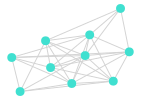

In [15]:
graphobj = Graph(10, 34)
gplot(graphobj)

In [16]:
cut = kargers_mincut(graphobj, adjacency_matrix(graphobj))

4

## How fast is it? 

Actually quite fast! At least compared to the first c++ and python implementations that come up on google! (I had to fix the c++ one, they did twice as much work as they had to do. I am not a very good c++ programmer)

I timed them on the same V=200, E=2517 graph but because actually evaluating the mincut would take forever, I capped the iterations at 200.

3 Python times (sec): 14.1346, 14.2936, 14.2722

3 C++ times (sec): 4.7646, 4.8759, 4.6284

3 Julia times (sec): 4.0618, 4.0675, 4.0925

The c++ code is not optimal but this still demonstrates Julia's ability to perform at a high level and compete with c++

## Karger-Stein 

$O(V^4*log(V))$ for dense graphs still isn't very good. Can we do better?

Yes. Turns out Karger thought this too and got together with Stein and they did do much better!

Here is the important insight. The first squish, probably isnt going to squish across the mincut, but as we go on, that becomes more and more likely. So we should sample more frequently from later in the process. 

Here is the pseudocode to the Karger-Stein Mincut Algorithm

    fastmincut(G)
    
        if V<6
        
            return mincut
            
        else
            t = 1+1/sqrt(2)
            
            squish graph randomly down to |V|= t --> G1
            
            squish graph randomly down to |V|= t --> G2
            
            return min( fastmincut(G1), fastmincut(G2) )
        
        

This process takes longer (it is $O(V^2*log(V))$) but it gets the right answer much more frequently so we only need to repeat it $O(log(V)^2)$ times to achieve a $1/V$ probability of not being correct

This bring our final run time to $O(V^2*log(V)^3)$ which is much much faster than our initial naive algorithm. The state of the art deterministic algorithm (Stoer-Wagner) is $O(V*E + V^2*log(V))$ so they are comparable for sparse graphs but Karger Stein is much faster for big, dense graphs

Also, consider that for a dense graph, an algorithm must touch at least every edge which is $O(V^2)$. $O(log(V)^3)$ is a relatively small multiplicative factor to be away from optimal. 

For my implementation, I used a slightly modified version of my original Kargers Mincut to find the mincut for when the graph gets down to below 6 vertices.

In [575]:
# so here is my implementation of Karger Stein

function kargers_mincut_mat(mat_in, n)
    howmany = n^2*log(n)*100 #seems high but the graph only has 6 nodes and I cant make mistakes here. 1/600 chance of mistake
    mincut = Inf
    #mat = adjacency_matrix(graph)
    #cousin = mat
    for i in 1:howmany
        mat = copy(mat_in)
        contender = matrix_mincut(mat)
        if contender<mincut && contender != 0
            mincut = contender
        end
    end
    return mincut
end

function squish(mat, inds, t)
    while size(inds)[1]>t
        pick = rand(inds)
        pick2 = rand(inds)
        while pick==pick2
            pick2 = rand(inds)
        end
        mat[:, pick] = mat[:,pick] + mat[:,pick2]
        mat[pick, :] = mat[pick, :] + mat[pick2, :]
        mat[pick, pick] = 0
        mat[pick2, :] = 0
        mat[:, pick2] = 0
        deleteat!(inds, findin(inds, [pick2]))
    end
    return mat, inds
end

function karger_stein_mincut(matrix, inds)
    big = size(inds)[1]
    if big<=6
        mincut = kargers_mincut_mat(matrix, 2*big)
        return mincut
    else
        t = 1+big/sqrt(2)
        in1 = copy(matrix)
        in2 = copy(matrix)
        #t = convert(Int64, t)
        mat1, ind1 = squish(in1, inds, t)
        mat2, ind2 = squish(in2, inds, t)
        return min(karger_stein_mincut(mat1, ind1), karger_stein_mincut(mat2, ind2))
    end
end

function ks_mincut(graph, graph_mat)
    n = nv(graph)
    top = log(n)^2/(log(10)^2)
    mincut = Inf
    for i in 1:top 
        inds = collect(1:n)
        graph_mat2 = copy(graph_mat)
        maybe = karger_stein_mincut(graph_mat2, inds)
        if maybe<mincut
            mincut = maybe
        end
    end
    return mincut
end

ks_mincut (generic function with 1 method)

So how well does this work? It should be faster! Lets start with a small-ish graph. V = 30, E = 120

In [577]:
graphobj = Graph(30, 120)

{30, 120} undirected graph

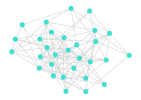

In [578]:
gplot(graphobj)

In [579]:
@time ks_mincut(graphobj, adjacency_matrix(graphobj))

  1.387879 seconds (5.35 M allocations: 584.746 MB, 7.88% gc time)


4

In [580]:
@time kargers_mincut(graphobj, adjacency_matrix(graphobj))

  1.253741 seconds (5.03 M allocations: 511.506 MB, 7.61% gc time)


4

So theyre about the same at this point

Lets try and even bigger graph, V=60, E = 400

In [752]:
graphobj = Graph(60, 400)

{60, 400} undirected graph

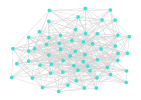

In [753]:
gplot(graphobj)

In [754]:
@time ks_mincut(graphobj, adjacency_matrix(graphobj))

  9.015860 seconds (22.56 M allocations: 3.284 GB, 5.72% gc time)


7

In [755]:
@time kargers_mincut(graphobj, adjacency_matrix(graphobj))

 22.054298 seconds (53.11 M allocations: 7.107 GB, 5.21% gc time)


7

Now there is starting to be a pronounced difference between the two algorithms in run time. Lets exaggerate it more and more

A bigger graph V = 80, E = 700

In [587]:
graphobj = Graph(80, 700)


{80, 700} undirected graph

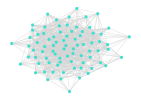

In [588]:
gplot(graphobj)

In [589]:
@time ks_mincut(graphobj, adjacency_matrix(graphobj))

 24.660723 seconds (48.26 M allocations: 7.882 GB, 4.88% gc time)


8

In [590]:
@time kargers_mincut(graphobj, adjacency_matrix(graphobj))

 75.303267 seconds (139.45 M allocations: 21.767 GB, 4.50% gc time)


8

It is clear that the Karger-Stein implementation is better.

# Normalized Cut and Image Segmentation

This is all adapted from "Normalized Cuts and Image Segmentation" by Jianbo Shi and Jitendra Malik http://repository.upenn.edu/cgi/viewcontent.cgi?article=1101&context=cis_papers

I was going to use Min-cut to do image segementation but it turns out there are better ways to do image segmentation and this one is more interesting so I'm going to focus on this.

## What is image segmentation?

![title](segment.png)

We want to cluster together pixels that come from the same object. You can image this is important in a lot of applications but lets focus on Photoshop. You wanna be able to drag an object out of its background easily

## Whats wrong with min-cut?

![title](bad_min.jpg)

Min-cut favors sparse regions, but that isn't super helpful for image segmentation. 

We want a "normalized cut" We want to split the graph into roughly equal sizes with as little cost as possible, unfortunately, this is NP-Complete. It can be reduced to Partition in polynomial time. 

Can we "almost" do it? Yes. Approximation algorithms dont always work well but in this case we can articulate normalized cut as an Integer Linear Programming problem and relax the integral contraint and end up with a decent answer. 

Let's define normalized cut. Define assoc(A, V): V is a graph and A is a subset of the graph. Assoc(A, V) is equal to the sum of the weights of edges connected to a vertex in A and a vertex outside of A. 

We define the normalized cut problem as minimize over cuts NCut(V) = Cut(A, B)/assoc(A, V) + Cut(B, A)/assoc(B, V). Note that this quantity is minimized if the Cut(A, B) is minimal and the Assoc(A,V) is equal to Assoc(B, V).

By making a continuous approximation we can make this solvable-ish

We a little bit of work it reduces to to an eigenvalue problem $D^{(-1/2)}(D-W)D^{(-1/2)}v = \lambda D v$

This turns out to be an interesting setup from a strictly graph theory perspective but all we need is the second smallest eigenvalue and eigenvector which correspond to the optimal partition. In the end we will have an eigenvector of length |V| and the cut will be defined by if a component of the vector is above or below a cutoff value. 

First step: It isn't trivially obvious how you would turn an image into a graph. So how do we do this?

So here is our image. It is 64 x 64. First were gonna turn it into a matrix

![title](dog.jpg)

Im going to convert it to HSV and make a tensor out of it

In [6]:
using Images, Colors, ImageCore;
pic = Images.load("dog.jpg")
cimg = float(Array(ImageCore.channelview(pic)))
size(cimg)

imhsv = convert(Image{HSV}, pic)
size(imhsv)
hsvimg = float(Array(ImageCore.channelview(imhsv)))
size(hsvimg)

(3,64,64)

In [7]:
using PyPlot

How are we gonna turn this into a graph problem? Let's start by making a vertex for every pixel. 

What about the edges? We're going to set up this graph as an adjacency matrix.

We're gonna make edges between nearby ish pixels and the magnitude of the weight will be related to the similarity of the pixel intensity. Here is the equation

$w_{ij} = e^{(-|| F(i) - F(j)||^2/ \sigma_i^2)}* \alpha$

where $\alpha$ = 0 if $|| X(i) - X(j) || > r$

else $\alpha$ = $e^{(-|| X(i) - X(j)||^2/ \sigma_X^2)}$

In [8]:
function getF(h, s, v)
   # h = pixel[1]
   # s = pixel[2]
   # v = pixel[3]
    out = [v, v*s*sin(h), v*s*cos(h)]
    return out
end

function get_top(f1, f2, sigma)
    dif = f1-f2
    out = norm(dif)^2/sigma
    return out
end

function xtop(i1, j1, i2, j2, sigma)
    top = (i1-i2)^2+(j1-j2)^2
    out = top/sigma
    return out, top
end

function precomputeF(img)
    one = size(img)[2]
    two = size(img)[3]
    out = ones(3, one,two)
    for i in 1:one
        for j in 1:two
            out[:, i,j] = getF(img[1,i,j], img[2,i,j], img[3,i,j])
        end
    end
    return out
end

function get_val(F1, F2, i1, i2, j1, j2, r, sigmaI, sigmaX)
    xtop1, dist = xtop(i1, j1, i2, j2, sigmaX)
    if dist>r
        return 0
    else
        almostf = get_top(F1, F2, sigmaI)
        first = e^(-almostf)
        second = e^(-xtop1)
        return first*second
    end
end

function makeW(img, r, sigmaI, sigmaX)
    one = size(img)[2]
    two = size(img)[3]
    precompute1 = precomputeF(img)
    out = eye(one*two, one*two)
    for i in 1:one
        for j in 1:two
            for k in 1:one
                for m in 1:two
                    F1 = precompute1[:, i,j]
                    F2 = precompute1[:, k,m]
                    val = get_val(F1, F2, i, k, j, m, r, sigmaI, sigmaX)
                    if i==k && j==m
                        val = 1
                    end
                    first_coor = (i-1)*one+j
                    sec_coor = (k-1)*one+m
                    out[first_coor, sec_coor]=val
                end
            end
        end
    end
    return out
end

makeW (generic function with 1 method)

In [9]:
@time W = makeW(hsvimg, 15, 0.1, 4)

  5.347405 seconds (85.93 M allocations: 4.428 GB, 10.54% gc time)


4096×4096 Array{Float64,2}:
 1.0       0.778681  0.367653  0.104522  …  0.0          0.0        
 0.778681  1.0       0.778681  0.365209     0.0          0.0        
 0.367653  0.778681  1.0       0.773743     0.0          0.0        
 0.104522  0.365209  0.773743  1.0          0.0          0.0        
 0.0       0.104415  0.365062  0.776648     0.0          0.0        
 0.0       0.0       0.104705  0.366243  …  0.0          0.0        
 0.0       0.0       0.0       0.105218     0.0          0.0        
 0.0       0.0       0.0       0.0          0.0          0.0        
 0.0       0.0       0.0       0.0          0.0          0.0        
 0.0       0.0       0.0       0.0          0.0          0.0        
 0.0       0.0       0.0       0.0       …  0.0          0.0        
 0.0       0.0       0.0       0.0          0.0          0.0        
 0.0       0.0       0.0       0.0          0.0          0.0        
 ⋮                                       ⋱               ⋮          
 0.0  

Now we need to compute the degree matrix which is the a diagonal matrix with each diagonal element equal to the sum of the corresponding row in W. 

In [10]:
function makeD(W)
    one = size(W)[1]
    out = ones(one)
    for i in 1:one
        val = sum(W[i,:])
        out[i] = val
    end
    return out
end

makeD (generic function with 1 method)

In [11]:
d = makeD(W)
D = Diagonal(d)

4096×4096 Diagonal{Float64}:
 5.05735   ⋅       ⋅        ⋅       …   ⋅       ⋅        ⋅        ⋅     
  ⋅       6.8062   ⋅        ⋅           ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅      7.62592   ⋅           ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅       7.84007      ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅           ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅       …   ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅           ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅           ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅           ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅           ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅       …   ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅           ⋅       ⋅        ⋅        ⋅     
  ⋅        ⋅       ⋅        ⋅           ⋅       ⋅        ⋅        ⋅     
 ⋮                    

We then set up our eigenvalue problem

In [13]:
first = inv(sqrt(D))
left = first*(D-W)*first
gonna = sparse(left)

4096×4096 sparse matrix with 175212 Float64 nonzero entries:
	[1   ,    1]  =  0.802268
	[2   ,    1]  =  -0.132723
	[3   ,    1]  =  -0.0592012
	[4   ,    1]  =  -0.0165991
	[65  ,    1]  =  -0.132742
	[66  ,    1]  =  -0.0891017
	[67  ,    1]  =  -0.0397403
	[68  ,    1]  =  -0.0111735
	[129 ,    1]  =  -0.0592434
	[130 ,    1]  =  -0.0397635
	⋮
	[3966, 4096]  =  -1.45467e-7
	[3967, 4096]  =  -1.21497e-7
	[3968, 4096]  =  -0.000500683
	[4029, 4096]  =  -0.0215249
	[4030, 4096]  =  -0.00121246
	[4031, 4096]  =  -1.50491e-5
	[4032, 4096]  =  -0.0103687
	[4093, 4096]  =  -2.90283e-5
	[4094, 4096]  =  -0.00090143
	[4095, 4096]  =  -0.000208921
	[4096, 4096]  =  0.0422049

We use Julia's wonderful eigenvalue calculator to find the 6 smallest eigenvalues and corresponding eigenvectors. It can't be over-emphasized how much the success of this depends on Julias wonderful eigensolver. 

In [14]:
u, v = eigs(left, nev = 6, which ="SM", maxiter = 600)

(Complex{Float64}[2.06988e-18+0.0im,0.0014412+0.0im,0.00155483+0.0im,0.00279786+0.0im,0.00331456+0.0im,0.004954+0.0im],
Complex{Float64}[-0.0117783+0.0im 0.0139842+0.0im … -0.0142164+0.0im -0.0145139+0.0im; -0.0136638+0.0im 0.0162296+0.0im … -0.0164414+0.0im -0.0167789+0.0im; … ; -0.00744001+0.0im -0.00880598+0.0im … 0.00304006+0.0im -0.021728+0.0im; -0.00535159+0.0im -0.00671058+0.0im … 0.00334558+0.0im -0.0191112+0.0im],

6,3,41,[-0.116042,-0.0260527,0.0108872,0.150963,0.221641,0.247141,0.162984,0.0934199,0.0802909,0.0792097  …  -0.00227302,0.247281,0.417967,-0.0941175,0.501741,1.64347,2.01657,2.1204,0.626293,1.46492])

In [15]:
u = real(u)

6-element Array{Float64,1}:
 2.06988e-18
 0.0014412  
 0.00155483 
 0.00279786 
 0.00331456 
 0.004954   

In [16]:
v = real(v)

4096×6 Array{Float64,2}:
 -0.0117783    0.0139842   -0.0112542   0.00683831  -0.0142164   -0.0145139
 -0.0136638    0.0162296   -0.013037    0.00792878  -0.0164414   -0.0167789
 -0.0144632    0.0171949   -0.0137653   0.00838697  -0.01731     -0.0176429
 -0.0146649    0.0174584   -0.0139003   0.00849291  -0.0173975   -0.0177032
 -0.0146756    0.0175049   -0.0138296   0.00848344  -0.0171921   -0.0174506
 -0.0146729    0.0175439   -0.0137238   0.00846083  -0.0169107   -0.0171109
 -0.0146655    0.0175879   -0.0135906   0.00843114  -0.0165625   -0.0166862
 -0.0146718    0.017656    -0.0134481   0.00840319  -0.0161715   -0.0162082
 -0.0146749    0.0177275   -0.0132801   0.00836666  -0.0157182   -0.015657 
 -0.0146761    0.0178064   -0.0130894   0.00832387  -0.0152077   -0.0150294
 -0.0146735    0.017888    -0.012874    0.00827198  -0.0146386   -0.0143295
 -0.0146657    0.0179716   -0.0126338   0.00821081  -0.0140129   -0.0135548
 -0.0146734    0.0180775   -0.0123836   0.00814722  -0.0133438 

I make a quick function which sets the values of the eigenvector to be between 0 and 1 and then plot the second smallest eigenvector as an image. Light and Dark regions correspond to belonging to different sides of the cut. 

In [20]:
function vecZero2One(vec)
    top = maximum(vec)
    bottom = minimum(vec)
    shape = size(vec)
    outgoing = (vec - bottom*ones(shape))/(top-bottom)
    return outgoing
end

vecZero2One (generic function with 1 method)

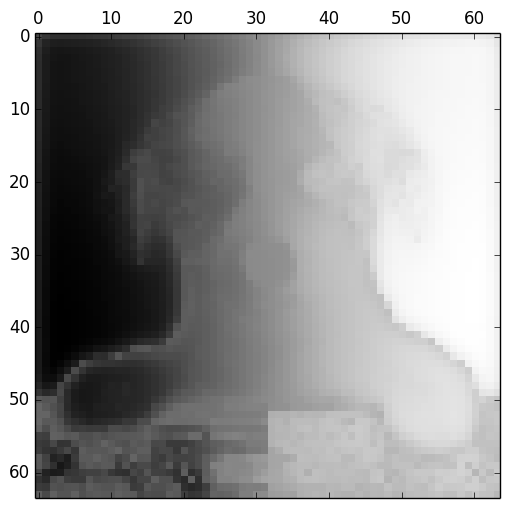

PyObject <matplotlib.image.AxesImage object at 0x32fd41650>

In [22]:
maybe = reshape(v[:,2], (64, 64))
maybe = vecZero2One(maybe)
matshow(maybe, cmap="Greys")

In [23]:
function putting_it_all_together(cimg, r, sigmaI, sigmaX, how_many)
    W = makeW(cimg, r, sigmaI, sigmaX)
    d = makeD(W)
    D = Diagonal(d)
    first = inv(sqrt(D))
    left = first*(D-W)*first
    u, v = eigs(left, nev = how_many, which ="SM", maxiter=500)
    return real(u), real(v)
end

putting_it_all_together (generic function with 1 method)

In [128]:
@time u, v = putting_it_all_together(hsvimg, 50, 0.03, 4, 6)

 11.966297 seconds (89.94 M allocations: 5.773 GB, 7.01% gc time)


([3.11858e-19,0.000264709,0.000505076,0.000669551,0.000755523,0.000972105],
[-0.0128079 0.00428706 … 0.0124237 -0.0114358; -0.0148284 0.00496263 … 0.0143977 -0.0132379; … ; -0.00670128 -0.0180794 … 0.00400757 0.0123402; -0.00565358 -0.00734182 … 0.000560829 0.0217541])

All things considered, it runs pretty fast. It has to manipulate and find the eigenvectors of a 4096 x 4096 matrix, note that the cut is quite sensitive to the parameters in calculating the W matrix. 

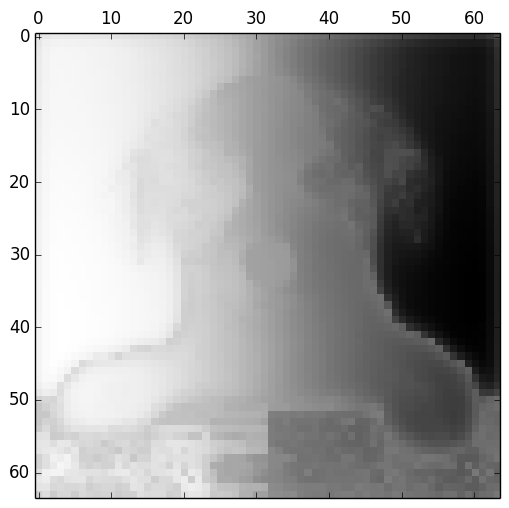

PyObject <matplotlib.image.AxesImage object at 0x3300722d0>

In [90]:
maybe = reshape(v[:,2], (64, 64))
maybe = vecZero2One(maybe)
matshow(maybe, cmap = "Greys")

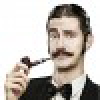

In [91]:
pic2 = Images.load("dude.jpeg")


In [92]:
imhsv2 = convert(Image{HSV}, pic2)
hsvimg2 = float(Array(ImageCore.channelview(imhsv2)));

@time u2, v2 = putting_it_all_together(hsvimg2, 5, 0.1, 0.5, 6)

  4.093501 seconds (31.79 M allocations: 2.111 GB, 15.12% gc time)


([-1.92126e-19,0.00027863,0.000306615,0.000619671,0.00100664,0.00113739],
[-0.0186151 -0.026044 … -0.00713107 -0.0247644; -0.019693 -0.0275401 … -0.00741514 -0.0259992; … ; -0.0196284 0.0414088 … 0.0312693 -0.0435337; -0.0185609 0.0391917 … 0.0296194 -0.0414331])

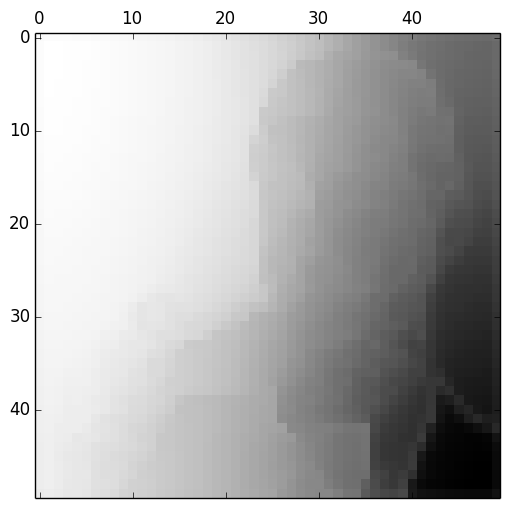

PyObject <matplotlib.image.AxesImage object at 0x33fbf6050>

In [93]:
maybe2 = reshape(v2[:,2], (50, 50))
maybe2 = vecZero2One(maybe2)
matshow(maybe2, cmap = "Greys")

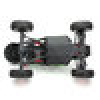

In [94]:
pic3 = Images.load("car2.jpg")

In [95]:
imhsv3 = convert(Image{HSV}, pic3)
hsvimg3 = float(Array(ImageCore.channelview(imhsv3)));

@time u3, v3 = putting_it_all_together(hsvimg3, 50, 0.03, 3, 6)

  3.903338 seconds (34.84 M allocations: 2.184 GB, 15.33% gc time)


([-3.19761e-17,0.000821589,0.00211763,0.002361,0.00404135,0.00444332],
[-0.0151092 0.019112 … 0.0264002 -0.00075669; -0.017569 0.0221877 … 0.0307283 -0.000953413; … ; -0.0175689 -0.0192737 … 0.0291431 -0.0100037; -0.0151092 -0.0166185 … 0.025099 -0.00849269])

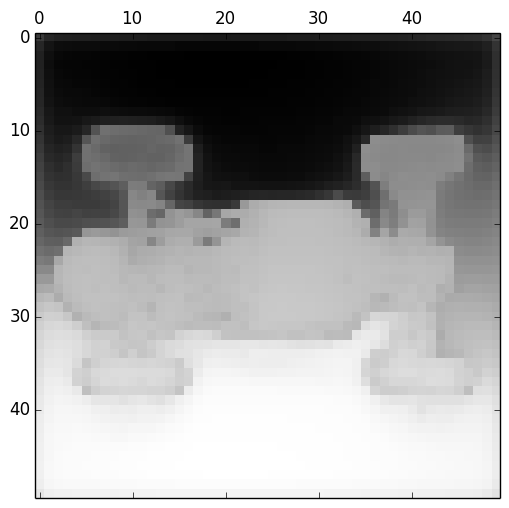

PyObject <matplotlib.image.AxesImage object at 0x32fa1d950>

In [96]:
maybe3 = reshape(v3[:,2], (50, 50))
maybe3 = vecZero2One(maybe3)
matshow(maybe3, cmap="Greys")

It does a pretty good job of identifying the object in the image! It seems to pick out the object and half of the background which is more or less what is expected. The full method for image segmentation using normalized cut is to iteratively cut each subgraph until it is satisfactorily segmented. 

In [124]:
function cut_pic(pic, v, val, x, set)
    pic3 = copy(pic)
    pic2 = reshape(pic3, (3, x^2))
    vu = v'
    vu = reshape(vu, (1, x^2))
    for i in 1:x^2
        if vu[i]<val
            pic2[:, i] = set
        end
    end
    out = reshape(pic2, (3, x, x))
    return out
end



cut_pic (generic function with 2 methods)

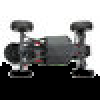

In [125]:
vcut = vecZero2One(v3[:,2])
vcut = reshape(vcut, (50, 50))
gonna_try3 = cut_pic(hsvimg3, vcut, 0.26, 50, 0);

colorview(HSV, gonna_try3[1, :, :] , gonna_try3[2, :, :],  gonna_try3[3, :, :])

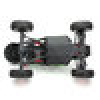

In [78]:
colorview(HSV, hsvimg3[1, :, :] , hsvimg3[2, :, :],  hsvimg3[3, :, :])

This worked really well! It found the border of the car really well! 

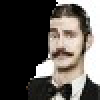

In [126]:
vcut = vecZero2One(v2[:,2])
vcut = reshape(vcut, (50, 50))
gonna_try2 = cut_pic(hsvimg2, vcut, 0.32, 50, 0);

colorview(HSV, gonna_try2[1, :, :] , gonna_try2[2, :, :],  gonna_try2[3, :, :])

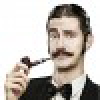

In [116]:
colorview(HSV, hsvimg2[1, :, :] , hsvimg2[2, :, :],  hsvimg2[3, :, :])

It finds the edge of the head but unfortunately swallows up the hand and gets the pipe edge confused. The pipe makes send because it is a hard edge. 

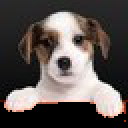

In [141]:
vcut = vecZero2One(v[:,2])
vcut = reshape(vcut, (64, 64))
gonna_try = cut_pic(hsvimg, vcut, 0.85, 64, 0);

colorview(HSV, gonna_try[1, :, :] , gonna_try[2, :, :],  gonna_try[3, :, :])

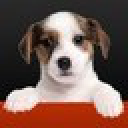

In [712]:
colorview(HSV, hsvimg[1, :, :] , hsvimg[2, :, :],  hsvimg[3, :, :])

This one works so well! It gets the edge of the paws precisely!!! 

# Conclusions

Using normalized cut to do image segmentation worked really well! It only took a few tweaks away from the code I showed in my presentation but it ended up as a viable product.

This project shows that graph cuts are both interesting and useful and that Julia is an excellent platform for conducting graph algorithms for high performance. 

I was able to implement two versions of randomized min cut algorithms that perform at a speed competitive with C++.

I then represented images as graphs and used normalized cut to segment the images. This was done with great success. 

In [2]:
Pkg.add("Inkscape")

LoadError: LoadError: unknown package Inkscape
 in macro expansion at ./pkg/entry.jl:53 [inlined]
 in (::Base.Pkg.Entry.##2#5{String,Base.Pkg.Types.VersionSet})() at ./task.jl:360
while loading In[2], in expression starting on line 1